In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from emlp.equivariant_subspaces import T,Scalar,Matrix,Vector,Quad,repsize
from emlp.groups import SO,O,Trivial,Lorentz,O13,SO13,SO13p
from emlp.mlp import MLP, EMLP,LieLinear
import itertools
import numpy as np
import torch
from emlp.datasets import Inertia,Fr,ParticleInteraction

In [ ]:
100*T(0)+30*T(1)+10*T(2)+3*T(3)+1*T(4)

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from oil.utils.utils import LoaderTo, cosLr, islice, export,FixedNumpySeed
from oil.tuning.study import train_trial
from oil.datasetup.datasets import split_dataset
from oil.model_trainers.classifier import Regressor
from functools import partial
import torch.nn as nn
#repmiddle = 100*T(0)+30*T(1)+10*T(2)+3*T(3)#+1*T(4)

def makeTrainer(*,dataset=ParticleInteraction,network=EMLP,num_epochs=500,ndata=1000+1000,seed=2020,aug=False,
                bs=500,lr=1e-2,optim=AdamW,device='cuda',split={'train':-1,'test':1000},
                net_config={'num_layers':3,'group':SO13p()},opt_config={'weight_decay':0*3e-6},
                trainer_config={'log_dir':None,'log_args':{'minPeriod':.02}},save=False):

    # Prep the datasets splits, model, and dataloaders
    torch.manual_seed(seed)
    with FixedNumpySeed(seed):
        datasets = split_dataset(dataset(ndata),splits=split)
    device = torch.device(device)
    model = network(datasets['train'].rep_in,datasets['train'].rep_out,**net_config).to(device)
    if aug: model = nn.Sequential(datasets['train'].default_aug_layers(),model)
    dataloaders = {k:LoaderTo(DataLoader(v,batch_size=bs,#shuffle=(k=='train'),
                num_workers=0,pin_memory=False),device) for k,v in datasets.items()}
    dataloaders['Train'] = dataloaders['train']
    opt_constr = partial(optim, lr=lr, **opt_config)
    lr_sched = cosLr(num_epochs)
    return Regressor(model,dataloaders,opt_constr,lr_sched,**trainer_config)

In [3]:
#trainer = makeTrainer(network=EMLP,lr=3e-3)
trainer = makeTrainer(network=MLP,lr=1e-3,aug=False)
trainer.train(500)

/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


   Minibatch_Loss  Train_MSE    lr0  test_MSE
0        0.713237   0.714136  0.001   0.90733
     Minibatch_Loss  Train_MSE      lr0  test_MSE
236        0.002633   0.003487  0.00087  0.577112
     Minibatch_Loss  Train_MSE       lr0  test_MSE
477    1.172617e-07   0.001087  0.000538  0.578226
     Minibatch_Loss  Train_MSE       lr0  test_MSE
723    1.168669e-08   0.001087  0.000179  0.578191
     Minibatch_Loss  Train_MSE       lr0  test_MSE
968    2.225221e-08   0.001093  0.000003  0.578177

     Minibatch_Loss  Train_MSE       lr0  test_MSE
999             NaN   0.001087  0.000001  0.578186


In [4]:
print(trainer.dataloaders['train'].dataset.Y)

tensor([ 0.3418, -0.2717, -0.1706,  ...,  0.0805,  0.1657,  0.0475])


In [6]:
trainer = makeTrainer(network=EMLP,lr=1e-4)
trainer.train(500)

[4T(1, 0) @ d=4, 112T(0, 0)+14T(0, 1)+14T(1, 0)+2T(0, 2)+2T(1, 1)+2T(2, 0)+T(0, 3) @ d=4, 112T(0, 0)+14T(0, 1)+14T(1, 0)+2T(0, 2)+2T(1, 1)+2T(2, 0)+T(0, 3) @ d=4, 112T(0, 0)+14T(0, 1)+14T(1, 0)+2T(0, 2)+2T(1, 1)+2T(2, 0)+T(0, 3) @ d=4]
BiW components:6704 dim:0 shape:(419, 16) rep:588T(0, 1)+56T(0, 2)+56T(1, 1)+8T(0, 3)+8T(1, 2)+8T(2, 1)+4T(0, 4) @ d=4
BiW components:160896 dim:33852 shape:(419, 384) rep:16464T(0, 0)+3626T(1, 0)+3626T(0, 1)+714T(2, 0)+910T(1, 1)+714T(0, 2)+203T(3, 0)+112T(2, 1)+112T(1, 2)+168T(0, 3)+22T(3, 1)+18T(4, 0)+12T(2, 2)+22T(1, 3)+18T(0, 4)+2T(3, 2)+2T(4, 1)+2T(5, 0)+2T(2, 3)+2T(1, 4)+2T(0, 5)+T(3, 3) @ d=4
BiW components:160896 dim:33852 shape:(419, 384) rep:16464T(0, 0)+3626T(1, 0)+3626T(0, 1)+714T(2, 0)+910T(1, 1)+714T(0, 2)+203T(3, 0)+112T(2, 1)+112T(1, 2)+168T(0, 3)+22T(3, 1)+18T(4, 0)+12T(2, 2)+22T(1, 3)+18T(0, 4)+2T(3, 2)+2T(4, 1)+2T(5, 0)+2T(2, 3)+2T(1, 4)+2T(0, 5)+T(3, 3) @ d=4


   Minibatch_Loss  Train_MSE     lr0  test_MSE
0        0.641174   0.708882  0.0001  0.902093
   Minibatch_Loss  Train_MSE     lr0  test_MSE
4        0.589038   0.708314  0.0001  0.901527
   Minibatch_Loss  Train_MSE     lr0  test_MSE
8        0.543397   0.707798  0.0001  0.901014
    Minibatch_Loss  Train_MSE     lr0  test_MSE
12         0.50262   0.707303  0.0001   0.90052
    Minibatch_Loss  Train_MSE     lr0  test_MSE
16        0.466091   0.706813  0.0001  0.900033
    Minibatch_Loss  Train_MSE     lr0  test_MSE
20        0.433319   0.706298  0.0001  0.899521
    Minibatch_Loss  Train_MSE     lr0  test_MSE
24        0.403871   0.705678  0.0001  0.898906
    Minibatch_Loss  Train_MSE     lr0  test_MSE
28        0.377351    0.70491  0.0001  0.898146
    Minibatch_Loss  Train_MSE     lr0  test_MSE
32        0.353399    0.70397  0.0001  0.897216
    Minibatch_Loss  Train_MSE     lr0  test_MSE
36        0.331684   0.702397  0.0001  0.895662
    Minibatch_Loss  Train_MSE     lr0  test_MS

KeyboardInterrupt: 

In [7]:
x,y = next(iter(trainer.dataloaders['train']))

In [10]:
rep = trainer.dataloaders['train'].dataset.rep_in

In [15]:
SO(3).samples(x.shape[0]).shape

(500, 3, 3)

In [ ]:
rep.rho(

Why is there a disconnect between MBLoss and Train_MSE for the standard MLP and EMLP? Why does train stall. (seems to be a small batch size small dataset size issue?)
Why do the EMLP models perform so much better with a small number of scalars?


In [4]:
import scipy as sp
from scipy.linalg import expm

In [9]:
x = next(iter(trainer.dataloaders['test']))[0]
xsmall = x[:1]
R = SO(3).sample()
Rin = torch.from_numpy(trainer.dataloaders['train'].dataset.rep_in.rho(R)).to(x.device,x.dtype)
Rout = torch.from_numpy(trainer.dataloaders['train'].dataset.rep_out.rho(R)).to(x.device,x.dtype)
from oil.utils.utils import Eval
with Eval(trainer.model):
    print(trainer.model(xsmall@Rin.T))
    print(trainer.model(xsmall)@Rout.T)

tensor([0.2587], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.2587], device='cuda:0', grad_fn=<SqueezeBackward3>)


In [9]:
from emlp.mlp import BiLinear
x = next(iter(trainer.dataloaders['test']))[0]
xsmall = x[:1]
R = SO(3).sample()

repin = trainer.dataloaders['train'].dataset.rep_in
repout = trainer.dataloaders['train'].dataset.rep_out

repout = repin
B = BiLinear(repin,repout)
B.cuda()
Rin = torch.from_numpy(repin.rho(R)).to(x.device,x.dtype)
Rout = torch.from_numpy(repout.rho(R)).to(x.device,x.dtype)
from oil.utils.utils import Eval

print(B(xsmall@Rin.T))
print(B(xsmall)@Rout.T)

BiW components:400 dim:125 shape:(20, 20) rep:25T(0)+50T(1)+25T(2) @ d=3
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.3432, -6.5503,  0.0089,
          0.8346,  5.1796, -3.5075, -2.9687,  0.5283,  1.5695, -2.7642,  4.2946,
          3.0159, -2.1696, -3.3314,  4.1213]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.3432, -6.5503,  0.0089,
          0.8346,  5.1796, -3.5075, -2.9687,  0.5283,  1.5695, -2.7642,  4.2946,
          3.0159, -2.1696, -3.3314,  4.1213]], device='cuda:0',
       grad_fn=<MmBackward>)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df_mlp['Model']="MLP"
df_e["Model"]="EMLP"
df_all = pd.concat([df_mlp,df_e])

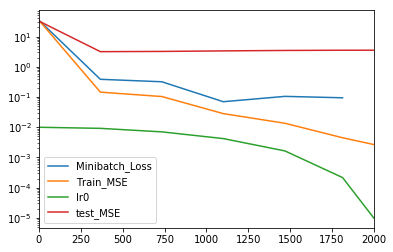

In [38]:
df_mlp.plot()
plt.yscale('log')

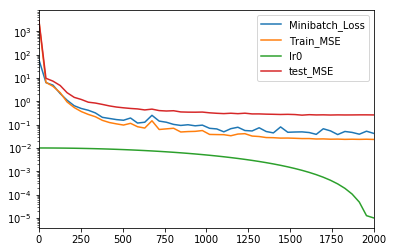

In [39]:
df_e.plot()
plt.yscale('log')

In [28]:

#df_e = trainer.logger.scalar_frame

sns.lineplot(y='test_MSE',data=df_all,hue="Model")
plt.yscale('log')
plt.show()

ValueError: Either both or neither of `x` and `y` must be specified (but try passing to `data`, which is more flexible).

In [21]:
#repmiddle = 30*T(0)+10*T(1)+5*T(2)+2*T(3)#+2*T(3,0)+2*T(2,1)+2*T(1,2)+2*T(0,3)
repmiddle =100*T(0)+30*T(1)+10*T(2)+3*T(3)#+2*T(3,0)+2*T(2,1)+2*T(1,2)+2*T(0,3)

In [22]:
repmiddle(e2)

2T(0)+2T(1)+2T(2)+T(3)+T(4) @ d=2

In [23]:
#(repmiddle*repmiddle.T).symmetric_subspace()[0]

In [24]:
#(repmiddle*repmiddle.T).size()

In [25]:
repmiddle*repmiddle#.T

4T(0)+8T(1)+12T(2)+12T(3)+12T(4)+8T(5)+5T(6)+2T(7)+T(8) @ d=2

In [26]:
from emlp.mlp import capped_tensor_product

In [27]:
v = repmiddle.show_subspace()

In [28]:
v

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970])

In [29]:
outrep,outv = cappedTensorProduct(repmiddle,v,repmiddle)

In [30]:
#(repmiddle*repmiddle).ranks

In [31]:
outrep.ranks

[(0, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (2, 0),
 (3, 0),
 (4, 0)]

In [32]:
v

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970])

In [33]:
outv

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970,   1.0000,   1.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000])

In [34]:
outrep.drho(e2[0])@outv.numpy()

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.38418579e-07,  2.38418579e-07,
        2.38418579e-07,  2.38418579e-07,  2.38418579e-07,  2.38418579e-07,
        2.38418579e-07, -2.38418579e-07,  2.38418579e-07,  2.38418579e-07,
        2.38418579e-07, -2.38418579e-07,  2.38418579e-07, -2.38418579e-07,
       -2.38418579e-07, -2.38418579e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [21]:
outrep.drho(e2[0]).shape

(16, 16)

$SO(2): \quad 1,\_, \delta_{ij},\_, \epsilon_{ij}, ...$

In [14]:
for i in range(8):
    print(f"T({i}): {T(i)(O(2)).symmetric_subspace()[0]}")

T(0): 1
T(1): 0
T(2): 0
T(3): 0
T(4): 0
T(5): 0
T(6): 0
T(7): 0


In [1]:
from emlp.equivariant_subspaces import T
from emlp.groups import SO,O,C,D,Scaling,Parity,TimeReversal,Lorentz,SO13p,SO13,Symplectic,Permutation
rep = T(2)(C(6))
A = rep.show_subspace()

In [2]:
T(0,2)(C(6))

T(2) @ d=2

In [4]:
import numpy as np
np.mean(np.zeros((0,3)))

nan

In [5]:
R = rep.G.sample()
Rrep = rep.rho(R)
print(Rrep@A.numpy())
print(A)

[-0.70710677  1.41421354 -1.41421354 -0.70710677]
tensor([-0.7071,  1.4142, -1.4142, -0.7071])


In [6]:
print(f"T({4}): {T(4)(e2).show_subspace().reshape(2,2,2,2)}")

NameError: name 'e2' is not defined

$SO(3): \quad 1, \_, \delta_{ij}, \epsilon_{ijk}, \delta_{ij}\delta_{k\ell}, \delta_{ik}\delta_{j\ell}, \delta_{jk}\delta_{i\ell}, ...$

In [11]:
for i in range(8):
    print(f"T({i}): {T(i)(e3).symmetric_subspace()[0]}")

T(0): 1
T(1): 0
T(2): 1
T(3): 1
T(4): 3
T(5): 6
T(6): 15
T(7): 36


$SO^+(1,3): \quad 1, \_, \delta_{\mu}^\nu, \eta_{\mu\nu}, \eta^{\mu\nu},\_,\epsilon_{\mu\nu\sigma\tau},\eta_{\mu\nu}\eta_{\sigma\tau},...$

In [1]:
from emlp.equivariant_subspaces import T
from emlp.utils import NoCache as nocache
from emlp.groups import SO,O,C,D,Scaling,Parity,TimeReversal,Lorentz,SO13p,SO13,Symplectic,Permutation,Trivial
for i in range(6):
    for j in range(i+1):
        print(f"T{i-j,j}: {T(i-j,j)(SO13).symmetric_subspace()[0]}")

T(0, 0): 1
T(1, 0): 0
T(0, 1): 0
T(2, 0): 1
T(1, 1): 1
T(0, 2): 1
T(3, 0): 0
T(2, 1): 0
T(1, 2): 0
T(0, 3): 0
T(4, 0): 3
T(3, 1): 3
T(2, 2): 3
T(1, 3): 3
T(0, 4): 3
T(5, 0): 0
T(4, 1): 0
T(3, 2): 0
T(2, 3): 0
T(1, 4): 0
T(0, 5): 0


In [2]:
for i in range(6):
    for j in range(i+1):
        print(f"T{i-j,j}: {T(i-j,j)(SO13p()).symmetric_subspace()[0]}")

T(0, 0): 1
T(1, 0): 0
T(0, 1): 0
T(2, 0): 1
T(1, 1): 1
T(0, 2): 1
T(3, 0): 0
T(2, 1): 0
T(1, 2): 0
T(0, 3): 0
T(4, 0): 4
T(3, 1): 4
T(2, 2): 4
T(1, 3): 4
T(0, 4): 4
T(5, 0): 0
T(4, 1): 0
T(3, 2): 0
T(2, 3): 0
T(1, 4): 0
T(0, 5): 0


#### $SO(2)_{xy}$ in $\mathbb{R}^3$

In [7]:
# for i in range(8):
#     print(f"T({i}): {T(i)(e3[:1]).symmetric_subspace()[0]}")

NameError: name 'e3' is not defined

Trivial in $\mathbb{R}^3$

In [3]:
for i in range(8):
    print(f"T({i}): {T(i)(Trivial(3)).symmetric_subspace()[0]}")

T(0): 1
T(1): 3
T(2): 9
T(3): 27
T(4): 81
T(5): 243
T(6): 729
T(7): 2187


$\mathrm{Sp}(1)$ Symplectic group

In [4]:
for i in range(6):
    for j in range(i+1):
        print(f"T{i-j,j}: {T(i-j,j)(Symplectic(2)).symmetric_subspace()[0]}")

T(0, 0): 1
T(1, 0): 0
T(0, 1): 0
T(2, 0): 1
T(1, 1): 1
T(0, 2): 1
T(3, 0): 0
T(2, 1): 0
T(1, 2): 0
T(0, 3): 0
T(4, 0): 3
T(3, 1): 3
T(2, 2): 3
T(1, 3): 3
T(0, 4): 3
T(5, 0): 0
T(4, 1): 0
T(3, 2): 0
T(2, 3): 0
T(1, 4): 0
T(0, 5): 0


In [ ]:
import pandas as pd

In [7]:
bell_numbers = [1,1,2,5,15,52,203,877]
k_max= 8
n_max=9
printstr = ""
#with nocache():
printstr+="       "
for n in range(2,n_max):
    printstr+=" n={:1d}".format(n)
    printstr+="  "
printstr+="b(k)\n"
printstr+="     "+"______"*(n_max-2)+"\n"
for k in range(k_max):

    printstr+=" k={:1d}|".format(k)
    for n in range(2,n_max):
        printstr+="  "
        if n**k<7000: printstr+="{:4d}".format(T(k)(Permutation(n)).symmetric_subspace()[0])
        else: printstr+="    "
        
        #print(f"S{n} T({k}): {T(k)(Permutation(n)).symmetric_subspace()[0]}")
    printstr+="| {:3d}\n".format(bell_numbers[k])
print(printstr)

        n=2   n=3   n=4   n=5   n=6   n=7   n=8  b(k)
     __________________________________________
 k=0|     1     1     1     1     1     1     1|   1
 k=1|     1     1     1     1     1     1     1|   1
 k=2|     2     2     2     2     2     2     2|   2
 k=3|     4     5     5     5     5     5     5|   5
 k=4|     8    14    15    15    15    15    15|  15
 k=5|    16    41    51    52                  |  52
 k=6|    32   122   187                        | 203
 k=7|    64   365                              | 877



In [21]:
T(2,0)(Symplectic(2)).show_subspace()

tensor([-1.2343,  0.0000,  0.0000,  0.0000,  0.0000, -0.9449, -0.2894,  0.0000,
         0.0000, -0.2894, -0.9449,  0.0000,  0.0000,  0.0000,  0.0000, -1.2343])

In [9]:
import numpy as np

In [10]:
np.ones(3)@e3

array([[ 0., -1.,  1.],
       [-1.,  0.,  1.],
       [-1.,  1.,  0.]])

In [11]:
e3.shape

(3, 3, 3)

In [1]:
from emlp.groups import *

In [6]:
M = O13.sample()

In [7]:
eta = np.eye(4)
eta[0,0]=-1

In [8]:
M.T@eta@M-eta

array([[-1.11022302e-15, -5.01459875e-16, -1.71810289e-16,
         1.19624964e-16],
       [-5.01459875e-16, -3.33066907e-16, -1.36956663e-16,
        -9.35976936e-17],
       [-1.71810289e-16, -1.36956663e-16,  2.22044605e-16,
         6.47558888e-17],
       [ 1.19624964e-16, -9.35976936e-17,  6.47558888e-17,
         0.00000000e+00]])

In [31]:
A = SO(2).sample()

In [32]:
A@A.T

array([[1.00000000e+00, 7.21013798e-17],
       [7.21013798e-17, 1.00000000e+00]])

In [8]:
sum([[i for i in range(j)] for j in range(4)],[])

[0, 0, 1, 0, 1, 2]

In [5]:
O(2).discrete_generators

array([[[-1., -0.],
        [-0., -1.]]])

In [11]:
import numpy as np
np.concatenate([np.zeros((3,4)),np.zeros((0,4))])

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [4]:
np.concatenate([np.arange(3),5+np.arange(3)]).reshape(2,3)

array([[0, 1, 2],
       [5, 6, 7]])

In [14]:
import collections
from emlp.equivariant_subspaces import size
def tensor_indices_dict(rep):
    index_dict = collections.defaultdict(list)
    i=0
    for rank in rep.ranks:
        i_end = i+size(rank,rep.d)
        index_dict[rank].append(np.arange(i,i_end))
        i = i_end
    return {rank:np.concatenate(ids) for rank,ids in index_dict.items()}

In [16]:
tensor_indices_dict((T(0)+3*T(2)+2*T(1)+T(0))(SO(3)))

{(0, 0): array([ 0, 34]),
 (2,
  0): array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 (1, 0): array([28, 29, 30, 31, 32, 33])}

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import dill,pickle

In [18]:
with open(os.path.expanduser('~/equivariant-MLP/experiments/EMLP_synthetic_study/results.df'),'rb') as f:
    df = pickle.load(f)

In [29]:
with open(os.path.expanduser('~/equivariant-MLP/experiments/EMLP_synthetic_study_aug/results.df'),'rb') as f:
    df2 = pickle.load(f)
    df2['group']='MLP+Aug'
    df2['dataset']='Fr'

In [30]:
df.loc[df['network']=='MLP','group']='MLP'
df_fr = df[df['dataset']=='Fr']
df_i = df[df['dataset']=='Inertia']
df_frwaug = pd.concat([df_fr,df2])

/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,num_epochs,train,log_suffix,Minibatch_Loss,Train_MSE,lr0,test_MSE,group
0,12000,25,trial0/,NaN,0.067273,0.000003,3.406097,MLP
1,6000,50,trial1/,NaN,0.014250,0.000003,1.671468,MLP
2,3000,100,trial2/,NaN,0.019037,0.000003,0.216648,MLP
3,750,400,trial3/,NaN,0.026743,0.000003,0.054095,MLP
4,300,1000,trial4/,0.225931,0.021691,0.000003,0.038507,MLP
5,100,3000,trial5/,NaN,0.044350,0.000003,0.063002,MLP
6,30,10000,trial6/,NaN,0.034367,0.000003,0.024869,MLP
7,12000,25,trial7/,NaN,0.041029,0.000003,3.349329,MLP
8,6000,50,trial8/,NaN,0.023225,0.000003,1.004375,MLP
9,3000,100,trial9/,NaN,0.019851,0.000003,0.228475,MLP


Text(0.5, 1.0, 'Fitting Moment of Inertia (5 point masses)')

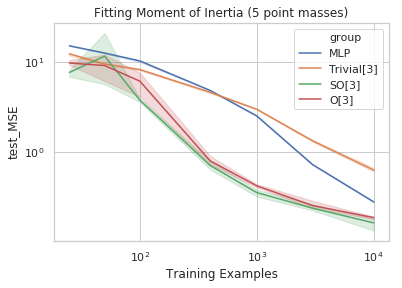

In [21]:
sns.set(style='whitegrid')
sns.lineplot(data=df_i,x='train',y='test_MSE',hue='group')
plt.xlabel('Training Examples')
plt.yscale('log')
plt.xscale('log')
plt.title("Fitting Moment of Inertia (5 point masses)")
#plt.xlim(25,10**4)

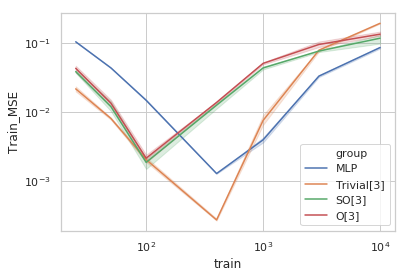

In [193]:
sns.lineplot(data=df_i,x='train',y='Train_MSE',hue='group')
plt.yscale('log')
plt.xscale('log')

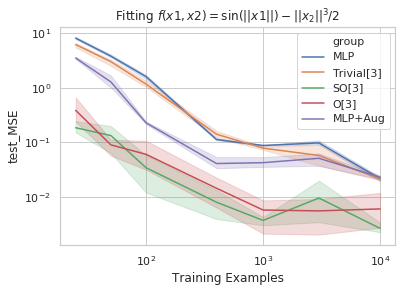

In [32]:
plt.title(r"Fitting $f(x1,x2) = \mathrm{sin}(\||x1\||)-\||x_2\||^3/2$")
sns.lineplot(data=df_frwaug,x='train',y='test_MSE',hue='group')
plt.xlabel('Training Examples')
plt.yscale('log')
plt.xscale('log')

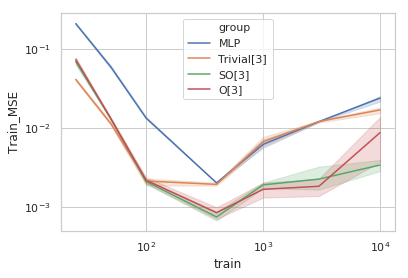

In [195]:
sns.lineplot(data=df_fr,x='train',y='Train_MSE',hue='group')
plt.yscale('log')
plt.xscale('log')

In [1]:
from emlp.groups import Symplectic

In [11]:
Sp = Symplectic(2)

In [12]:
S = Sp.sample()

In [4]:
import numpy as np

In [14]:
J = np.array([[0, 1],[-1.,0]])
Omega = np.kron(J,np.eye(2))

In [15]:
S.T@Omega@S-Omega

array([[-1.36100489e-16, -9.54867495e-17,  0.00000000e+00,
         8.70343569e-18],
       [-2.75402255e-17, -7.19633725e-17,  6.39748495e-17,
         2.22044605e-16],
       [-2.22044605e-16, -7.59323587e-17,  1.59813831e-17,
         1.96336273e-16],
       [ 9.48105133e-17, -2.22044605e-16, -2.14029412e-16,
         1.67250872e-17]])

In [23]:
0*[1]

[]

In [8]:
from emlp.mlp import uniform_rep,uniform_allocation
from emlp.groups import Symplectic,Lorentz,SO,O

In [9]:
SO3 = SO(3)

In [10]:
uniform_rep(384,SO3)

102T(0)+34T(1)+11T(2)+3T(3) @ d=3

In [7]:
uniform_rep(384,Lorentz).size()

384

In [6]:
143//2**4

8

In [1]:
import scipy as sp
import scipy.special
from emlp.equivariant_subspaces import T

In [2]:
sp.special.binom(4,3)

4.0

In [3]:
np.zeros((3,4)).reshape([4,3])

NameError: name 'np' is not defined

In [1]:
from emlp.equivariant_subspaces import drho, drho_lazy, T, rho,rho_lazy
from emlp.groups import Lorentz,O,SO
import numpy as np

In [40]:
rank = (3,3)
G = Lorentz
M = (np.random.randn(G.lie_algebra.shape[0])[:,None,None]*G.lie_algebra).sum(0)

#dr2 = drho_lazy(M,rank)*np.eye(G.d**sum(rank))

In [41]:
drl = drho_lazy(M,rank)

In [42]:
import scipy
import scipy.sparse
import numpy as np
U,S,V = scipy.sparse.linalg.svds(drl,which='SM',k=90,tol=1e-5)

In [43]:
L,Q = scipy.sparse.linalg.eigsh(drl.T@drl,sigma=0,k=90)

ValueError: Error in inverting M: function gmres_loose did not converge (info = 40960).

In [37]:
Q = scipy.sparse.linalg.minres(drl.T@drl,np.zeros((drl.shape[1],42)))

ValueError: A and b have incompatible dimensions

In [9]:
(S>1e-3).sum()

48

In [16]:
V.shape

(90, 65536)

In [19]:
a = (drl@V.T)

In [31]:
(a[:,(S<1e-5)]**2).mean(0)

array([0.00049378, 0.00049163, 0.00049717, 0.0004959 , 0.00049454,
       0.00049651, 0.00049194, 0.00048909, 0.00049317, 0.00049607,
       0.00049382, 0.0004957 , 0.00050339, 0.00049546, 0.00049036,
       0.00049405, 0.00049981, 0.00048893, 0.00049454, 0.00049405,
       0.00049449, 0.00049556, 0.00049875, 0.00049513, 0.00049029,
       0.00049397, 0.00048986, 0.00048615, 0.00049308, 0.00049599,
       0.00049725, 0.00048554, 0.00049619, 0.0004951 , 0.0004974 ,
       0.00049785, 0.00048609, 0.00049357, 0.00049869, 0.00050101,
       0.00049311, 0.00049581])

In [6]:
dr = drho(M,rank)
%timeit np.linalg.svd(dr,full_matrices=False)

2.42 s ± 4.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
a,b,c = np.linalg.svd(dr,full_matrices=False)

In [17]:
c.shape

(2187, 2187)

In [12]:
(b<1e-8).sum()

393

In [13]:
(b>1e-6).sum()

1794

In [23]:
U2.shape

(27, 27)

In [24]:
U.shape

(27, 10)

In [27]:
U2[-6:]-U[:,:6]

array([[ 0.53620943, -0.00256057, -0.17947038, -0.1647883 ,  0.26363003,
        -0.26291738,  0.26373772,  0.31729468, -0.05550727,  0.02657079,
         0.06667226,  0.2736735 ,  0.4268051 ,  0.03756258,  0.12234059,
        -0.22068874, -0.05171853,  0.17194761,  0.26701322, -0.35167309,
         0.58496815, -0.09815643, -0.05719358, -0.07701386,  0.25301376,
         0.12877441, -0.03385442],
       [ 0.52912226,  0.06865191,  0.01351972,  0.37797441,  0.26863571,
        -0.23249508, -0.01799347, -0.06405006,  0.16600934, -0.06765509,
        -0.2914878 , -0.35895634,  0.04625461,  0.34979808, -0.12254849,
        -0.39726869,  0.41801148,  0.01168394, -0.55212132,  0.47692821,
        -0.12886704,  0.28722357, -0.43194779, -0.29775601,  0.12794596,
         0.49714715,  0.21220599],
       [ 0.14126866, -0.07154802,  0.58171284,  0.13713865, -0.18712019,
        -0.11761939,  0.08561837,  0.31238878,  0.33441877,  0.1033827 ,
        -0.07411729,  0.17562329, -0.07541426, -0.1110

In [3]:
np.linalg.norm(dr2-dr)/(np.linalg.norm(dr2)+np.linalg.norm(dr))

0.0

In [4]:
dr

array([[ 0.        , -0.41294998, -0.02023324, -0.60958842],
       [-0.41294998,  0.        , -0.06949501,  0.99914336],
       [-0.02023324,  0.06949501,  0.        , -0.63595889],
       [-0.60958842, -0.99914336,  0.63595889,  0.        ]])

In [5]:
dr2

array([[ 0.        , -0.41294998, -0.02023324, -0.60958842],
       [-0.41294998,  0.        , -0.06949501,  0.99914336],
       [-0.02023324,  0.06949501,  0.        , -0.63595889],
       [-0.60958842, -0.99914336,  0.63595889,  0.        ]])

In [39]:
7*3**6

5103